# Bayes Factor Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import logsumexp

from pypesto import sample, optimize, visualize, variational

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load models


In [2]:
from mixture_models import problem1 as mixture_problem1, problem2 as mixture_problem2, Y as mixture_data, true_log_evidence_m1, true_log_evidence_m2, true_params

n_obs = len(mixture_data)

models = {
'mixture_model1': {
    'name': 'Alternative-Model',
    'true_evidence': true_log_evidence_m1,
    'prior_mean': np.array([0]),
    'prior_std': np.array([1]),
    'prior_cov': np.diag([1]),
    'problem': mixture_problem1,
    #'true_params': None
}, 
'mixture_model2': {
    'name': 'True-Model',
    'true_evidence': true_log_evidence_m2,
    'prior_mean': np.array([-2, 2]),
    'prior_std': np.array([2, 2]),
    'prior_cov': np.diag([4, 4]),
    'true_params': true_params,
    'problem': mixture_problem2,
}}

for m in models.values():         
    # neg_log_likelihood is called with full vector, parameters might be still in log space
    m['neg_log_likelihood'] = lambda x: m['problem'].objective._objectives[0](
        m['problem'].get_full_vector(x=x, x_fixed_vals=m['problem'].x_fixed_vals)
    )    
    # log_prop_posterior is called with reduced vector, parameters might be still in log space
    #m['log_prop_posterior'] = lambda x: -m['problem'].objective([m['problem'].get_reduced_vector(x)]) 

# Optimization

In [3]:
# check if file exists, if not run optimization
for m in models.values(): 
    m['results'] = optimize.minimize(problem=m['problem'],
                                        n_starts=1000)
    m['BIC'] = len(m['problem'].x_free_indices) * np.log(n_obs) + 2 * m['neg_log_likelihood'](m['results'].optimize_result.x[0])
    print(m['name'], 'BIC:', m['BIC'])

100%|██████████| 1000/1000 [00:00<00:00, 1355.54it/s]


Alternative-Model BIC: 43.372602583740566


100%|██████████| 1000/1000 [00:01<00:00, 723.63it/s]


True-Model BIC: 40.86567600091456


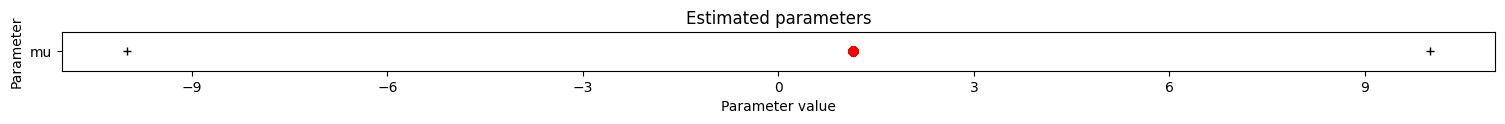

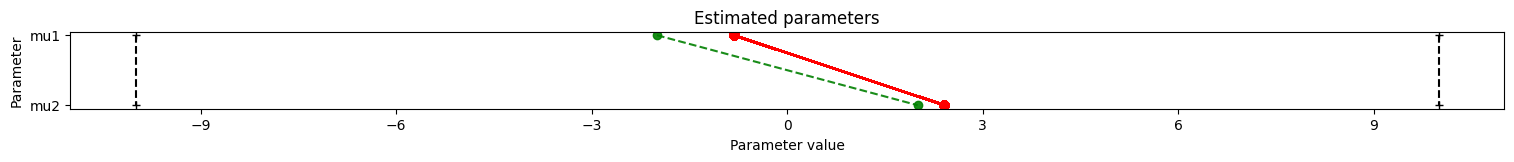

In [4]:
for m in models.values(): 
    if 'true_params' in m.keys():
        visualize.parameters(
            results=m['results'], 
            reference={
                'x': m["true_params"], 
                'fval': m['problem'].objective(m["true_params"])
            }
        )
    else:
        visualize.parameters(m['results'])

# Arithmetic Mean Estimator

- sample from prior
- mean over likelihood

In [5]:
%%time
for m in models.values():    
    prior_sample = np.random.multivariate_normal(mean=m['prior_mean'], 
                                                 cov=m['prior_cov'],
                                                 size=1000)
    log_likelihoods = np.array([-m['neg_log_likelihood'](x) for x in prior_sample])
    m['arithmetic_log_evidence'] = logsumexp(log_likelihoods) - np.log(log_likelihoods.size)
    
    print(m['name'], f'arithmetic mean: {m["arithmetic_log_evidence"]}')

Alternative-Model arithmetic mean: -21.90036671355837
True-Model arithmetic mean: -20.0564670552328
CPU times: user 65.2 ms, sys: 6.95 ms, total: 72.2 ms
Wall time: 67.6 ms


# Laplace Approximation
$p(\mathcal{D}) \approx 2\pi^{\frac{k}{2}} \vert F(\mathcal{D}\mid\theta^*) \vert^{-\frac12} p(\mathcal{D}\mid \theta^*)p(\theta^*)$ and 
$F=\frac{\partial^2 \ln (p(\mathcal{D}\mid \theta)p(\mathcal{D}))}{\partial \theta_{i} \theta_{j}}$

In [6]:
%%time
for m in models.values(): 
    laplace_evidences = []
    for x in m['results'].optimize_result.x:
        log_evidence= optimize.util.laplace_approximation_log_evidence(m['problem'], x)
        laplace_evidences.append(log_evidence)
                
        m['laplace_evidences'] = np.array(laplace_evidences)
    print(m['name'], f'laplace approximation: {m["laplace_evidences"][0]}')

Alternative-Model laplace approximation: -21.81550659859593
True-Model laplace approximation: -20.058270674327332
CPU times: user 350 ms, sys: 28.7 ms, total: 379 ms
Wall time: 358 ms


# Harmonic Mean Estimator

$$
p(\mathcal{D}\mid M_{k})
\approx \frac{1}{\frac{1}{n} \sum_{i=1}^n \frac{1}{p(\mathcal{D}\mid \theta_{i}, M_{k})}}  
$$


In [9]:
%%time
for m in models.values(): 
    m['results'] = sample.sample(
        problem=m['problem'], 
        n_samples=1000, 
        result=m['results'],
    )
    geweke_test = sample.geweke_test(m['results'])    
    m[f'burn_in'] = m['results'].sample_result.burn_in
    
    # compute harmonic mean
    neg_log_posterior = m['results'].sample_result.trace_neglogpost[0, m[f'burn_in']:]
    neg_log_prior = m['results'].sample_result.trace_neglogprior[0, m[f'burn_in']:] 
    m['harmonic_log_evidence'] = sample.util.harmonic_mean_log_evidence(neg_log_posterior, neg_log_prior)
    print(m['name'], f'harmonic mean: {m["harmonic_log_evidence"]}')    
    
    # compute stabilized harmonic mean
    prior_samples = np.random.multivariate_normal(mean=m['prior_mean'], 
                                                 cov=m['prior_cov'],
                                                 size=100)
    m['harmonic_stabilized_log_evidence'] = sample.util.harmonic_mean_log_evidence(
        trace_neglogpost=m['results'].sample_result.trace_neglogpost[0, m[f'burn_in']:],
        trace_neglogprior=m['results'].sample_result.trace_neglogprior[0, m[f'burn_in']:],
        prior_samples=prior_samples,
        neg_log_likelihood_fun=m['neg_log_likelihood']
    )
    print(m['name'], f'stabilized harmonic mean: {m["harmonic_stabilized_log_evidence"]}')

100%|██████████| 1000/1000 [00:00<00:00, 6498.48it/s]
Elapsed time: 0.1597559999999998
Geweke burn-in index: 50


Alternative-Model harmonic mean: -21.669322971632614
Alternative-Model stabilized harmonic mean: -21.763864008397597


100%|██████████| 1000/1000 [00:00<00:00, 5771.88it/s]
Elapsed time: 0.17929700000000004
Geweke burn-in index: 350


True-Model harmonic mean: -19.760837830081748
True-Model stabilized harmonic mean: -20.27230047206036
CPU times: user 360 ms, sys: 19.4 ms, total: 379 ms
Wall time: 369 ms


# Nested Sampling

In [10]:
%%time
for m in models.values():
    # define prior transformation needed for nested sampling
    def prior_transform(u):
        """Transform prior sample from unit cube to normal prior."""
        t = stats.norm.ppf(u)  # convert to standard normal
        Csqrt = np.linalg.cholesky(m['prior_cov'])  # Cholesky decomposition
        x = np.dot(Csqrt, t)  # correlate with appropriate covariance
        x += m['prior_mean']  # add mean
        return x

    # initialize nested sampler
    nested_sampler = sample.DynestySampler(
        sampler_args={'nlive': 500},
        dynamic=False  # static sampler is optimized for evidence computation
    )
    nested_sampler.prior_transform = prior_transform
    
    # run nested sampling
    result_dynesty_sample = sample.sample(
        problem=m['problem'],
        n_samples=None,
        sampler=nested_sampler
    )

    # extract log evidence
    m[f'nested_log_evidence'] = nested_sampler.sampler.results.logz[-1]
    print(m['name'], f'nested sampling: {m["nested_log_evidence"]}')

Assuming 'prior_transform' is correctly specified. If 'x_priors' is not uniform, 'prior_transform' has to be adjusted accordingly.
1213it [00:00, 1424.91it/s, +500 | bound: 0 | nc: 1 | ncall: 6005 | eff(%): 31.117 | loglstar:   -inf < -20.273 <    inf | logz: -21.799 +/-  0.014 | dlogz:  0.001 >  0.509]
Elapsed time: 0.8814729999999997
Assuming 'prior_transform' is correctly specified. If 'x_priors' is not uniform, 'prior_transform' has to be adjusted accordingly.


Alternative-Model nested sampling: -21.79860385694418


1407it [00:01, 964.79it/s, +500 | bound: 0 | nc: 1 | ncall: 8492 | eff(%): 23.861 | loglstar:   -inf < -18.070 <    inf | logz: -20.031 +/-  0.040 | dlogz:  0.001 >  0.509]
Elapsed time: 1.5246759999999995


True-Model nested sampling: -20.030562434873048
CPU times: user 2.41 s, sys: 157 ms, total: 2.57 s
Wall time: 2.47 s


# Thermodynamic Integration

In [11]:
%%time
for m in models.values():
    # initialize parallel tempering sampler
    ti_sampler = sample.ParallelTemperingSampler(  # not adaptive, since we want fixed temperatures
        internal_sampler=sample.AdaptiveMetropolisSampler(),
        n_chains=10
    )

    # run mcmc with parallel tempering
    result_ti = sample.sample(
                            problem=m['problem'], 
                            n_samples=1000, 
                            sampler=ti_sampler,
                            result=m['results']
                        )    
    # compute log evidence via thermodynamic integration
    m['thermodynamic_log_evidence'] = ti_sampler.compute_log_evidence(result_ti)
    print(m['name'], f'thermodynamic integration: {m["thermodynamic_log_evidence"]}')
    
    # compute log evidence via steppingstone sampling
    m['steppingstone_log_evidence'] = ti_sampler.compute_log_evidence(result_ti, method='steppingstone')
    print(m['name'], f'steppingstone sampling: {m["steppingstone_log_evidence"]}')

Initializing betas with "beta decay".
100%|██████████| 1000/1000 [00:01<00:00, 554.03it/s]
Elapsed time: 1.903689
Geweke burn-in index: 0
Geweke burn-in index: 0
Initializing betas with "beta decay".


Alternative-Model thermodynamic integration: -21.782335051349268
Alternative-Model steppingstone sampling: -21.81230610344762


100%|██████████| 1000/1000 [00:01<00:00, 531.55it/s]
Elapsed time: 1.9119699999999966
Geweke burn-in index: 150
Geweke burn-in index: 150


True-Model thermodynamic integration: -20.13214102050611
True-Model steppingstone sampling: -20.11439225735659
CPU times: user 3.83 s, sys: 237 ms, total: 4.07 s
Wall time: 3.94 s


# Using variational inference

In [12]:
%%time
for m in models.values():
    
    # one could define callbacks to check convergence during optimization
    # import pymc as pm
    # cb = [
    #     pm.callbacks.CheckParametersConvergence(
    #         tolerance=1e-3, diff='absolute'),
    #     pm.callbacks.CheckParametersConvergence(
    #         tolerance=1e-3, diff='relative'),
    # ]

    pypesto_variational_result = variational.variational_fit(
        problem=m['problem'],
        method='advi',
        n_iterations=10000,
        n_samples=None,
        result=m['results'],
        #callbacks=cb,
    )
    
    # negative elbo, this is bound to the evidence (optimization criterion)
    vi_lower_bound = np.max(-pypesto_variational_result.variational_result.data.hist)
            
    # compute harmonic mean from posterior samples
    approx_sample = pypesto_variational_result.variational_result.sample(1000)['trace_x'][0]
    neg_log_likelihoods = np.array([m['neg_log_likelihood'](ps) for ps in approx_sample])
    m['vi_harmonic_log_evidences'] = sample.util.harmonic_mean_log_evidence(
        trace_neglogpost=neg_log_likelihoods,
        trace_neglogprior=np.zeros(neg_log_likelihoods.size)
    )
    print(m['name'], f'variational inference (harmonic mean): {m["vi_harmonic_log_evidences"]}')
    print("evidence lower bound:", vi_lower_bound)
    
    # evidence cannot be smaller than the lower bound
    m["vi_harmonic_log_evidences"] = max(m["vi_harmonic_log_evidences"], vi_lower_bound)

Finished [100%]: Average Loss = 25.009
Elapsed time: 2.777738000000003


Alternative-Model variational inference (harmonic mean): -23.60168410498926
evidence lower bound: -22.95699854160757


Finished [100%]: Average Loss = 26.174
Elapsed time: 2.996016000000001


True-Model variational inference (harmonic mean): -21.08012103575074
evidence lower bound: -23.303709096838208
CPU times: user 6.14 s, sys: 301 ms, total: 6.44 s
Wall time: 6.72 s


# Comparison

In [13]:
labels = [
        '-1/2 BIC',
        'Arithmetic Mean',
        'Laplace', 
        'Harmonic Mean', 
        'Stabilized\nHarmonic Mean',
        'Nested Sampling',
        'Thermodynamic\nIntegration',
        'Steppingstone\nSampling',
        'Variational Inference\nHarmonic Mean'
]

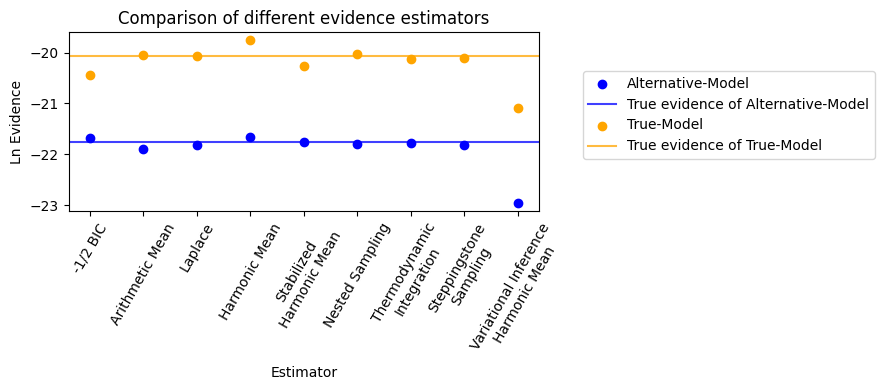

In [14]:
fig, ax = plt.subplots(1, 1, tight_layout=True, sharey=True, sharex=True, figsize=(6, 4))
colors = ['blue', 'orange']

for i, m in enumerate(models.values()):
    evidences = [
        -1/2*m['BIC'],
        m['arithmetic_log_evidence'],
        m['laplace_evidences'][0],
        m['harmonic_log_evidence'],
        m['harmonic_stabilized_log_evidence'],
        m['nested_log_evidence'],
        m['thermodynamic_log_evidence'],
        m['steppingstone_log_evidence'],
        m['vi_harmonic_log_evidences']
    ]
    ax.scatter(x=np.arange(len(evidences)), y=evidences, color=colors[i], label=m['name'])    
    ax.axhline(m['true_evidence'], color=colors[i], alpha=0.75, label=f'True evidence of {m["name"]}')
    ax.set_xlabel('Estimator')
    ax.set_title(f'Comparison of different evidence estimators')
    ax.set_xticks(ticks=np.arange(len(evidences)), labels=labels, rotation=60)
ax.set_ylabel('Ln Evidence')
fig.legend(ncols=1, loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.show()

# Bayes Factor

In [15]:
bayes_factors = [
    -1/2*models['mixture_model2']['BIC']+1/2*models['mixture_model1']['BIC'],
    models['mixture_model2']['arithmetic_log_evidence']-models['mixture_model1']['arithmetic_log_evidence'],
    models['mixture_model2']['laplace_evidences'][0]-models['mixture_model1']['laplace_evidences'][0],
    models['mixture_model2']['harmonic_log_evidence']-models['mixture_model1']['harmonic_log_evidence'],
    models['mixture_model2']['harmonic_stabilized_log_evidence']-models['mixture_model1']['harmonic_stabilized_log_evidence'],
    models['mixture_model2']['nested_log_evidence']-models['mixture_model1']['nested_log_evidence'],
    models['mixture_model2']['thermodynamic_log_evidence']-models['mixture_model1']['thermodynamic_log_evidence'],
    models['mixture_model2']['steppingstone_log_evidence']-models['mixture_model1']['steppingstone_log_evidence'],
    models['mixture_model2']['vi_harmonic_log_evidences']-models['mixture_model1']['vi_harmonic_log_evidences']
]

true_bf = models['mixture_model2']['true_evidence'] - models['mixture_model1']['true_evidence']

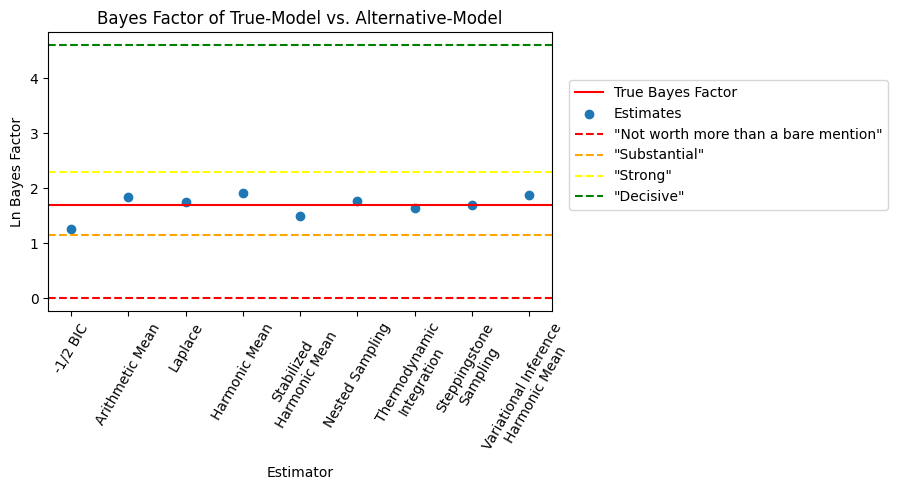

In [16]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 5))
ax.axhline(true_bf, linestyle='-', color='r', label='True Bayes Factor')
plt.scatter(x=np.arange(len(bayes_factors)), y=bayes_factors, label='Estimates')

# add decision thresholds
c = lambda x: np.log(np.power(10, x))  # usually defined in log10, convert to ln
ax.axhline(c(0), color='red', linestyle='--', label='"Not worth more than a bare mention"')
ax.axhline(c(0.5), color='orange', linestyle='--', label='"Substantial"')
ax.axhline(c(1), color='yellow', linestyle='--', label='"Strong"')
ax.axhline(c(2),  color='green', linestyle='--', label='"Decisive"')

ax.set_ylabel('Ln Bayes Factor')
ax.set_xlabel('Estimator')
ax.set_title(f'Bayes Factor of {models["mixture_model2"]["name"]} vs. {models["mixture_model1"]["name"]}')
plt.xticks(ticks=np.arange(len(bayes_factors)), labels=labels, rotation=60)
fig.legend(ncols=1, loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.show()